In [46]:
import numpy as np
%load_ext autoreload
%autoreload 0
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import Parameter

from estimator import Estimator
from estimator import BasicEstimator

In [48]:
from qiskit import Aer, execute
qasm_simulator = Aer.get_backend('qasm_simulator')

In [49]:
from pauli_string import PauliString
from hamiltonian import MolecularFermionicHamiltonian
from mapping import JordanWigner
from scipy.optimize import minimize
from solver import VQESolver

In [50]:
def read_integrals(distance):
    with open('H2_hamiltonian_integrals/Integrals_H2_no_spin_d_'+str(distance)+'.npz','rb') as f:

        out = np.load(f)
        h1_load_no_spin = out['h1']
        h2_load_no_spin = out['h2']
        energy_nuc =  out['energy_nuc']
        distance = out['distance']

    molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1_load_no_spin,h2_load_no_spin).include_spin()

    mapping = JordanWigner()
    qubit_hamiltonian = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian).sort()
    qubit_hamiltonian = qubit_hamiltonian.apply_threshold().combine().apply_threshold().sort()
    return (qubit_hamiltonian, energy_nuc)



def initial_state_circuit():
    varform_4qubits_1param = QuantumCircuit(4)
    a = Parameter('a')
    varform_4qubits_1param.x(0)
    varform_4qubits_1param.rx(a,1)
    varform_4qubits_1param.cx(1,0)
    varform_4qubits_1param.cx(0,2)
    varform_4qubits_1param.cx(1,3)
    
    return varform_4qubits_1param

def Estimator(read_integrals, initial_state_circuit):
    qubit_hamiltonian = read_integrals(distance)[0]
    varform = initial_state_circuit()
    backend = qasm_simulator
    execute_opts = {'shots' : 2048}
    estimator = BasicEstimator(varform, backend,execute_opts = execute_opts)
    estimator.set_observable(qubit_hamiltonian)
    params = [0,]
    expected_value = estimator.eval(params)
    
    return estimator

minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5,'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 0})

In [68]:
distance_array = np.arange(0.2,2.5,0.2)
opt_param_list = []
Ground_state_energy = []
for i, distance in enumerate(distance_array):
    distance = np.round(distance,decimals = 3)
    qubit_hamiltonian = read_integrals(distance)[0]
    energy_nuc = read_integrals(distance)[1]
    

    estimator = Estimator(read_integrals, initial_state_circuit)
    vqe_solver = VQESolver(estimator,minimizer,[0,],name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)
#     print('Ground state position estimate (vqe) : ', vqe_solver.last_opt_params)
#     print('Ground state energy estimate (electronic, vqe) : ', opt_value)
    opt_param_list.append(vqe_solver.last_opt_params)
    Ground_state_energy.append(opt_value + energy_nuc)
    print('Ground state energy estimate at distance '+str(distance)+' (molecular, vqe) : ', opt_value + energy_nuc)

Ground state energy estimate at distance 0.2 (molecular, vqe) :  0.16101247248467
Ground state energy estimate at distance 0.4 (molecular, vqe) :  -0.904722878249526
Ground state energy estimate at distance 0.6 (molecular, vqe) :  -1.1014675599312667
Ground state energy estimate at distance 0.8 (molecular, vqe) :  -1.1120223448331517
Ground state energy estimate at distance 1.0 (molecular, vqe) :  -1.0647213300546854
Ground state energy estimate at distance 1.2 (molecular, vqe) :  -1.0059262044927957
Ground state energy estimate at distance 1.4 (molecular, vqe) :  -0.945215324556256
Ground state energy estimate at distance 1.6 (molecular, vqe) :  -0.8768961857248145
Ground state energy estimate at distance 1.8 (molecular, vqe) :  -0.8298169643077574
Ground state energy estimate at distance 2.0 (molecular, vqe) :  -0.7873355631136172
Ground state energy estimate at distance 2.2 (molecular, vqe) :  -0.7458793867820019
Ground state energy estimate at distance 2.4 (molecular, vqe) :  -0.71

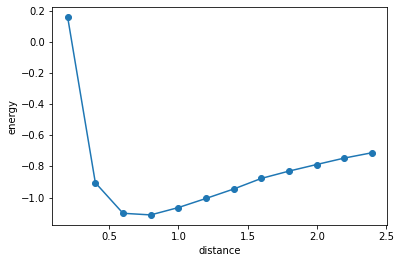

In [69]:
plt.plot(distance_array, Ground_state_energy, 'o-')
plt.xlabel('distance')
plt.ylabel('energy')
plt.show()

In [70]:
eigenstate_qc_list = []
counts_list = []
for i, distance in enumerate(distance_array):
    varform = initial_state_circuit()
    eigenstate_qc = varform.copy()
    eigenstate_qc.measure_all()
    opt_params = opt_param_list[i]

    param_dict = dict(zip(eigenstate_qc.parameters,opt_params))
    eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)
    
    execute_opts = {'shots' : 1024}
    job = execute(eigenstate_qc,backend=qasm_simulator,**execute_opts)
    result = job.result()
    counts = result.get_counts(eigenstate_qc)
    
    eigenstate_qc_list.append(eigenstate_qc)
    counts_list.append(counts)


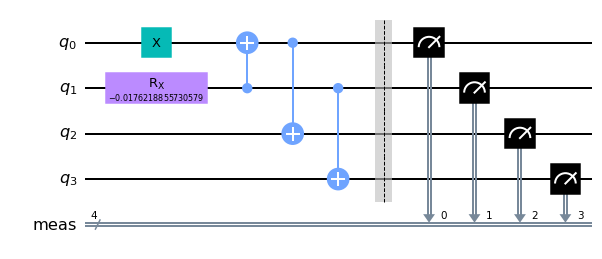

{'0101': 1024}

In [71]:
i = 0
display(eigenstate_qc_list[i].draw('mpl'))
counts_list[i]

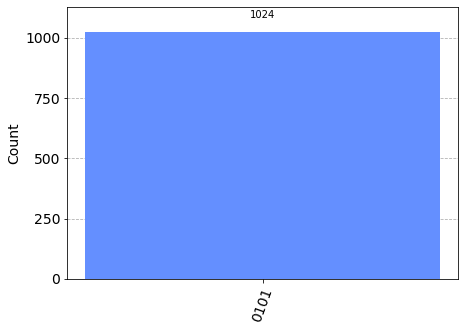

In [72]:
from qiskit.visualization import plot_histogram
plot_histogram(counts_list[i])